## Libraries

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from datetime import date
import datetime
import requests
import json

import xdmod.datawarehouse as xdw
import xdmod.visualizer as v

## Configuration

In [26]:
# list of all clusters with SUPReMM Quality REST endpoint
hosts = ["https://metrics-dev.ccr.buffalo.edu:9004"]

# today -> monday when notebook is executed
today = date.today()
sunday = today - datetime.timedelta(days=1)
last_monday = today - datetime.timedelta(days=7)
last_sunday = sunday - datetime.timedelta(days=1)
lastlast_monday = last_monday - datetime.timedelta(days=7)

## Report Visualization

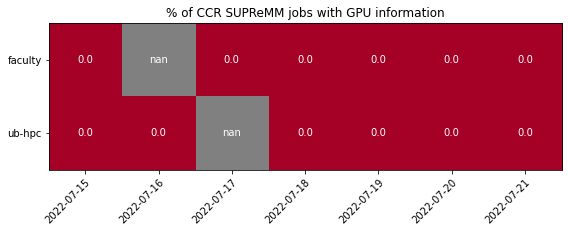

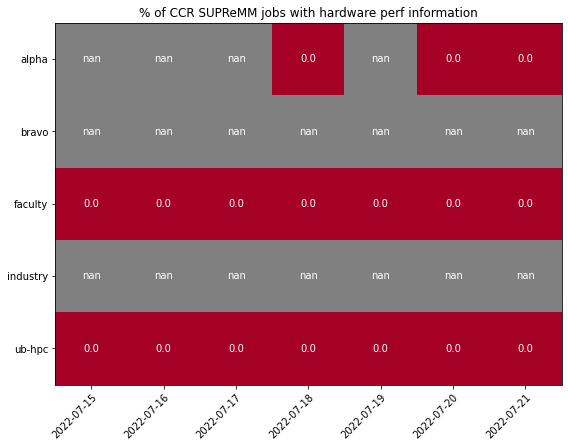

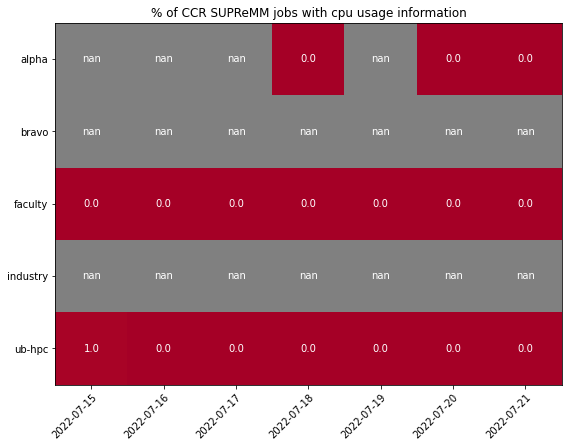

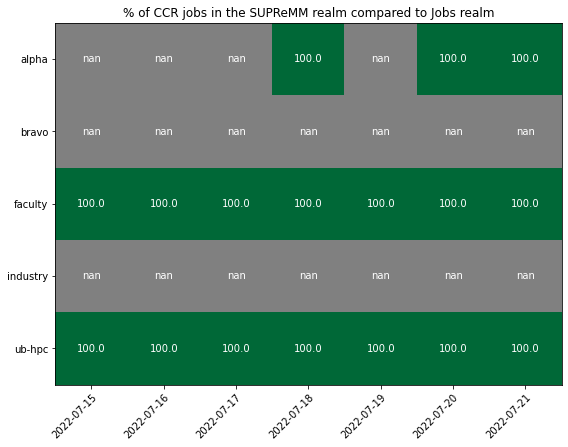

In [24]:
for host in hosts:
    for type in ['gpu', 'hardware', 'cpu','realms']:
        config = {"start": last_monday, "end": sunday, "type": type}                
        with xdw.DataWareHouse(host) as test:
                data = test.get_qualitydata(config)
                v.quality_heatmap(data)

## Alerts Setup

In [29]:
# path to report in html format
html_path = f'reports/xdmod-alerts/{today.strftime("%Y_%m_%d")}.html'

# Slack webhook for post request
# DO NOT EXPOSE ON GITHUB
webhook = ''

In [21]:
type_to_title = {'gpu': '% of CCR SUPReMM jobs with GPU information', 
                'hardware': '% of CCR SUPReMM jobs with hardware perf information', 
                'cpu': '% of CCR SUPReMM jobs with cpu usage information', 
                'script': '% of CCR SUPReMM jobs with Job Batch Script information', 
                'realms': '% of CCR jobs in the SUPReMM realm compared to Jobs realm'}

payload = {"blocks": [{"type": "section","text": {"type": "mrkdwn","text": f'*SUPReMM Quality Alerts {today}*'}}]}

for host in hosts:
    with xdw.DataWareHouse(host) as warehouse:
        for type in ['gpu', 'hardware', 'cpu', 'realms']:
            today_data = warehouse.get_qualitydata({"start": last_monday, "end": sunday, "type": type})
            lastweek_data = warehouse.get_qualitydata({"start": lastlast_monday, "end": last_sunday, "type": type})
            for res in today_data.index:
                if lastweek_data.mean(axis='columns')[res] + today_data.mean(axis='columns')[res] >= 10: # change to minus
                    alert = today_data.loc[res]
                    payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": f'Attention needed at: *{type_to_title[type]}* from the {alert.name} resource'}})

    payload['blocks'].append({"type": "section","text": {"type": "mrkdwn","text": f'{host}/{html_path}'}})                
                
    response = requests.post(webhook, data = json.dumps(payload))
    print(response.text)

ok


In [30]:
print(html_path)

reports/xdmod-alerts/2022_07_22.html
